### <font color='black'>Data cleaning</font>

<font color='#404040'>In this notebook, we will clean and summarize the data with appropriate techniques. The goal is to generate dataset for machine learning.</font>

In [1]:
import pandas as pd
import ast
import missingno

### <font color='black'>Import data</font>

<font color='#404040'>First, we import data collected in the previous notebook with relative paths. Then, we sample some observations to develop an initial understanding for the dataset.</font>

In [2]:
# Read data
dat_oxford = pd.read_csv('./data/oxford.csv')
dat_edinburgh = pd.read_csv('./data/edinburgh.csv')
dat_warwick = pd.read_csv('./data/warwick.csv')

<font color='#404040'>The first line consists of column headers, including name, data, degree and review categories. Not all categories are properly filled. Some of them are missing entries.</font>

In [3]:
# Raw data
dat_oxford.sample(5)

,name,date,degree,score_OVERALL UNIVERSITY RATING,OVERALL UNIVERSITY RATING,score_Job Prospects,Job Prospects,score_Course and Lecturers,Course and Lecturers,score_Uni Facilities,...,score_Do you think your time at university this year has been value for money?,Do you think your time at university this year has been value for money?,score_Students' Union,Students' Union,score_Accommodation,Accommodation,score_Local life,Local life,score_Societies and Sports,Societies and Sports
329,Student Reviewer,24 Feb 15,History,rat4,{'Tell us about your overall university experi...,rat4,NaN,rat4,NaN,rat3,...,NaN,NaN,rat1,NaN,rat5,NaN,rat5,NaN,rat4,NaN
42,Sarah,22 Jan 20,Mathematics and Computer Science MMath,rat3,{'Tell us about your overall university experi...,rat3,NaN,rat3,NaN,rat4,...,NaN,NaN,rat1,NaN,rat4,NaN,rat5,NaN,rat3,NaN
324,Student Reviewer,24 Feb 15,Georgraphy,rat4,{'Tell us about your overall university experi...,rat4,NaN,rat4,NaN,rat3,...,NaN,NaN,rat3,NaN,rat4,NaN,rat4,NaN,rat4,NaN
30,Laurie,24 Jan 20,Mathematics MMath,rat4,{'Tell us about your overall university experi...,rat4,{'How does your uni make efforts to increase y...,rat4,NaN,rat5,...,NaN,NaN,rat2,"{""What do you think of your Students' Union in...",rat3,"{'What do you think about the safety, conditio...",rat5,NaN,rat5,NaN
152,Student Reviewer,12 Jan 18,Economics MPhil,rat4,{'Tell us about your overall university experi...,rat1,{'How does your uni make efforts to increase y...,rat3,NaN,rat4,...,NaN,NaN,rat3,"{""What do you think of your Students' Union in...",NaN,NaN,rat5,NaN,rat4,{'How would you rate the variety of societies/...


### <font color='black'>Missing values</font>

<font color='#404040'>We use *[missingno](https://github.com/ResidentMario/missingno)* to explore the patterns of missing values in the data. For all universities, the columns *name*, *date*, *Overall University Ranking* and *those related to the rating scores* have <u>no missing values</u>. However, the matrix of missing values is sparse for the remaining columns. In other words, the remaining columns, representing review categories, have <u>lots of missing values</u>. Text mining often requires a large amount of data. In such situation, we cannot take a feature (e.g. *Uni Facilities*) and feed it to the model because there are just too few non-missing observations.</font>

<font color='#404040'>Dropping those columns can be a solution to the presence of a substantial amount of missing values. However, it may lead to a loss of information because reviews in the *Overall University Ranking* may not cover those in other review categories. Hence, we decide to concatenate the comments from different categories together, which represents an overall review from a student towards the university.</font>

<AxesSubplot:>

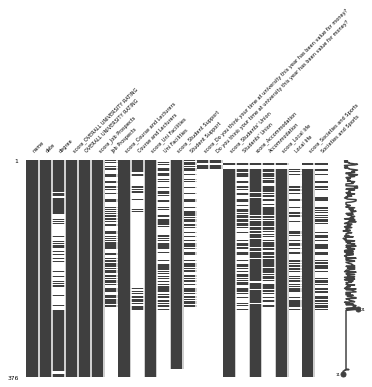

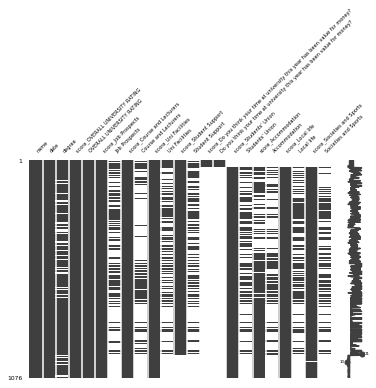

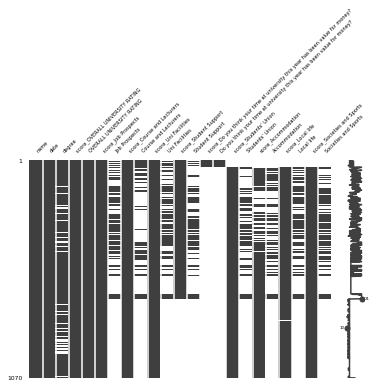

In [4]:
# Missing values
missingno.matrix(dat_oxford, figsize = (6, 4), fontsize = 5)
missingno.matrix(dat_edinburgh, figsize = (6, 4), fontsize = 5)
missingno.matrix(dat_warwick, figsize = (6, 4), fontsize = 5)

<font color='#404040'>Now, we write a function to concatenate reviews for each category together, as a global review. The function involves a looping for each category, and convert string to dictionary using *[ast.literal_eval](https://www.kite.com/python/answers/how-to-differentiate-eval()-and-ast.literal_eval()-in-python)* because each entry in the dataframe is stored as a dictionary during data collection.</font>

In [5]:
def concat_comments(comments):
    # Concatenate comments into a long string
    summary = ''
    
    # Loop through each review category
    for comment in comments:
        
        # If the category is not empty
        if pd.isnull(comment) is False:
            # Loop through each review question and answer within the same category
            for key, val in ast.literal_eval(comment).items():
                
                # Update if the answer is not None
                if val is not None:
                    summary = summary + ' ' + val
    
    return summary

<font color='#404040'>We create a new column called *reviews* which stores the concatenated comments, and remove observations that have only rating scores without leaving any textual comments.</font>

In [6]:
def clean_comments(dat_uni):
    # Columns which do *not* start with "score_"
    mask_score = ~dat_uni.columns.str.startswith('score_')
    dat_uni = dat_uni[dat_uni.columns[mask_score]]
    
    # Reviews start at the 3rd columns
    # axis = 1 for row-wise operation
    return dat_uni[dat_uni.columns[3:]].apply(lambda x: concat_comments(x), axis = 1)

In [7]:
# Store in the 'reviews' column
dat_oxford['reviews'] = clean_comments(dat_oxford)
dat_edinburgh['reviews'] = clean_comments(dat_edinburgh)
dat_warwick['reviews'] = clean_comments(dat_warwick)

In [8]:
def remove_empty(dat_uni):
    # Rows with empty string in 'reviews' after stripping
    mask_empty = (dat_uni['reviews'].str.strip() == '')
    
    # Remove mask_empty == True
    return dat_uni[~mask_empty]

In [9]:
# Remove observations with empty comments
dat_oxford = remove_empty(dat_oxford)
dat_edinburgh = remove_empty(dat_edinburgh)
dat_warwick = remove_empty(dat_warwick)

### <font color='black'>Export data</font>

<font color='#404040'>Now we have an initial understanding of the data, and they are saved under the *data* folder.</font>

In [10]:
# Export data
def export_data(dat_uni, name_uni):
    # Columns which start with "score_"
    mask_score = dat_uni.columns.str.startswith('score_')
    selected_col = dat_uni.columns[mask_score].tolist()
    
    # Other columns
    selected_col.extend(['name', 'date', 'degree', 'reviews'])
    
    # Save files
    dat_uni[selected_col].to_csv('./data/' + name_uni + '_sum.csv', index = False)

In [11]:
export_data(dat_oxford, 'oxford')
export_data(dat_edinburgh, 'edinburgh')
export_data(dat_warwick, 'warwick')